In [1]:
import numpy as np
from scipy.stats import chisquare
from scipy.stats import gmean
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas
import pandas as pd

C:\Users\samga\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def geo_mean(returns):
    geo = []
    n = len(returns.transpose())
    for i in range(0,n):
        geo = geo + [np.exp(np.log(rets[:,i]+1).mean())-1]
    return geo

In [218]:
def RTMVO(mu,Q,x0):
    
    # Penalty on Turnover (very sensitive)
    c = 0
    # Penalty on variance
    lambd = 40
    # Pentalty on returns
    rpen = 1
    # Max weight of an asset
    max_weight = 0.2
    # between 0% and 200%
    turnover = 2
    #size of uncertainty set
    ep = 2
    
    T = np.shape(mu)[0]
    Theta = np.diag(np.diag(Q))/T
    sqrtTh = np.diag(matrix(np.sqrt(Theta)))
    n = len(Q)
    
    # Make Q work for abs value
    Q = matrix(np.block([[Q, np.zeros((n,n)), np.zeros((n,n))], [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))], [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))]]))

    # A and B
    b1 = np.ones([1,1])
    b2 = x0


    A = matrix(np.block([[np.ones(n), c * np.ones(n), -c * np.ones(n)], [np.eye(n), np.eye(n), -np.eye(n)]]))
    b = np.concatenate((b1,b2))

    # G and h
    G = matrix(0.0, (6 * n + 1, 3 * n))
    h = opt.matrix(0.0, (6 * n + 1, 1))
    for k in range(3 * n):
        # xi > 0 constraint
        G[k, k] = -1
    # xi > max_weight
        G[k + 3 * n, k] = 1
        h[k + 3 * n] = max_weight
    for k in range(2 * n):
        # sum dwi+ + dwi- < turnover
        G[6 * n, k + n] = 1

    h[6 * n] = turnover



    quad = lambd*Q
    r = matrix(np.block([rpen*np.array(mu) - ep*sqrtTh, -c * np.ones(2*n)]))
    print(np.shape(r))
    
    return np.transpose(np.array(qp(matrix(quad), -1*matrix(r), matrix(G), matrix(h), matrix(A), matrix(b))['x'])[0:50])[0].tolist()

    

In [219]:
prices = pd.read_csv('prices.csv',header=None).to_numpy()
rets = prices[1:,:]/prices[0:-1,:] -1

mu = geo_mean(rets)
Q = np.cov(rets.transpose())
n = len(Q)
x0 = matrix(np.ones(n)*1/n)


In [220]:
aa = RTMVO(mu,Q,x0)

(150, 1)
     pcost       dcost       gap    pres   dres
 0:  1.0450e-02 -3.0383e+01  4e+02  6e+00  1e+01
 1:  1.0615e-02 -2.3525e+01  2e+01  1e-15  4e-15
 2:  1.0603e-02 -3.0039e-01  3e-01  3e-16  2e-15
 3:  9.9383e-03 -4.0599e-02  5e-02  1e-16  3e-16
 4:  8.9689e-03 -3.0202e-02  4e-02  2e-16  2e-16
 5:  7.8916e-03  1.4220e-03  6e-03  2e-16  3e-17
 6:  7.3414e-03  5.7894e-03  2e-03  2e-16  2e-17
 7:  7.2010e-03  6.8603e-03  3e-04  4e-16  1e-17
 8:  7.1731e-03  7.1058e-03  7e-05  3e-16  1e-17
 9:  7.1669e-03  7.1641e-03  3e-06  2e-16  1e-17
10:  7.1666e-03  7.1666e-03  3e-08  5e-16  1e-17
Optimal solution found.


'Bar-Graph---turnover.png'

<Figure size 640x480 with 0 Axes>

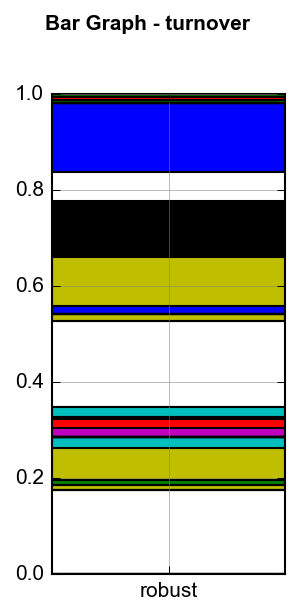

In [228]:
import sys
sys.path.insert(1,r'C:\Users\samga\OneDrive\Desktop\Charts')
#sys.path.insert(1,r'C:\Users\Owner\OneDrive\Desktop\Charts')

import SGCharts
ch = SGCharts.Chart('Bar Graph - turnover',figsize=[2,4])
accum = 0
for i in aa:
    accum = i + accum
    ch.ax.bar('robust',height = [i],bottom = [accum])

#ch.ax.bar('robust',height)

ch.ax.set_ylim([0,1])

ch.render()